# Analysis of lightning discharges as seen on a Software Defined Radio

## Experimental Setup:
RTL-SDR connected to a Linux laptop running Ubuntu. Radio tuned to 30MHz and ~4s of time series (I,Q) data collected at 2Ms/s. Radio is connected to a "rabbit ears" dipole antenna inside my home. 30MHz was choses as it is fairly quiet and as low frequency as the device will go without additional hardware. 

Noise is around .3 units so only data containing peaks about 0.5 units are saved using a numpy save file. These files are saved and timestamped for future analysis. This notebook shows what we can see during a lightning storm on a very simple (~$35) SDR set up. There is a lot we can do to improve this! 

Our goal is to equip Sage nodes with SDRs in the future to test these as a affordable ubiquitios lightbing detection network. Future work includes using am upconvertor to access lower frequencies. 
<img src='./rtl-sdr.jpg'>

In [10]:
#Import the goodness
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
%matplotlib inline

In [11]:
#load a time series file. Collected at 1626 UTC on the 19th of July
ts = np.load('/users/scollis/data/sage_lightning/data/event_200719_1626_00_0p6896.npy', allow_pickle=True).item()

In [12]:
#Create a time array using the known sampling frequency
dt = 1./2.048e6
xtime = np.arange(len(ts['sig'])) * dt


Text(0.5, 0, 'Time since start (s)')

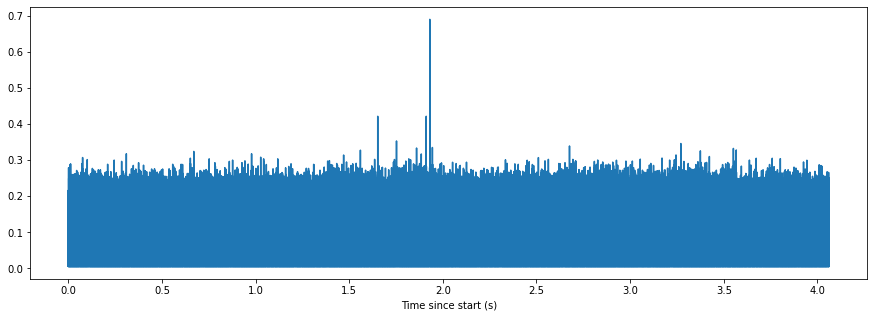

In [13]:
#Quick and dirty look at the data, note we use np.abs as the signal is complex

myfi = plt.figure(figsize=[15,5])
plt.plot(xtime, np.abs(ts['sig']))
plt.xlabel('Signal (Arb)')
plt.xlabel('Time since start (s)')

In [5]:
#Quick code to find the element where the maximum of the signal is

maxme = np.where(np.abs(ts['sig']) == np.max(np.abs(ts['sig'])))[0][0]
t_max = xtime[maxme]
print(t_max)

1.9303056640625


In [17]:
#What time window do we want to look at?
window = 4e-3

(1.9283056640625, 1.9323056640625)

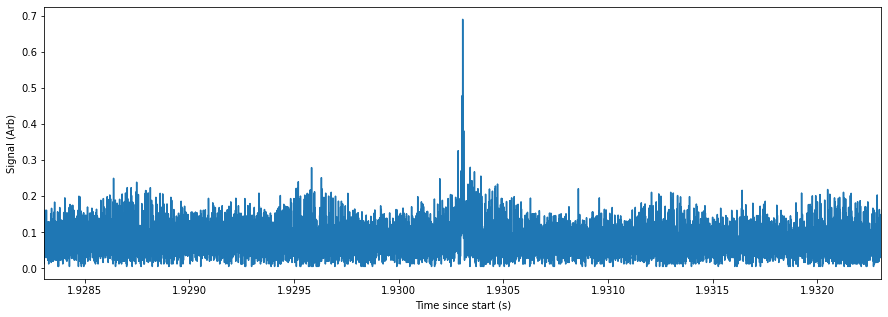

In [18]:
#Zoom in to the max signal times
myfi = plt.figure(figsize=[15,5])
plt.plot(xtime, np.abs(ts['sig']))
plt.ylabel('Signal (Arb)')
plt.xlabel('Time since start (s)')
t0 = t_max - window/2.
t1 =  t_max + window/2.
plt.xlim([t0,t1])

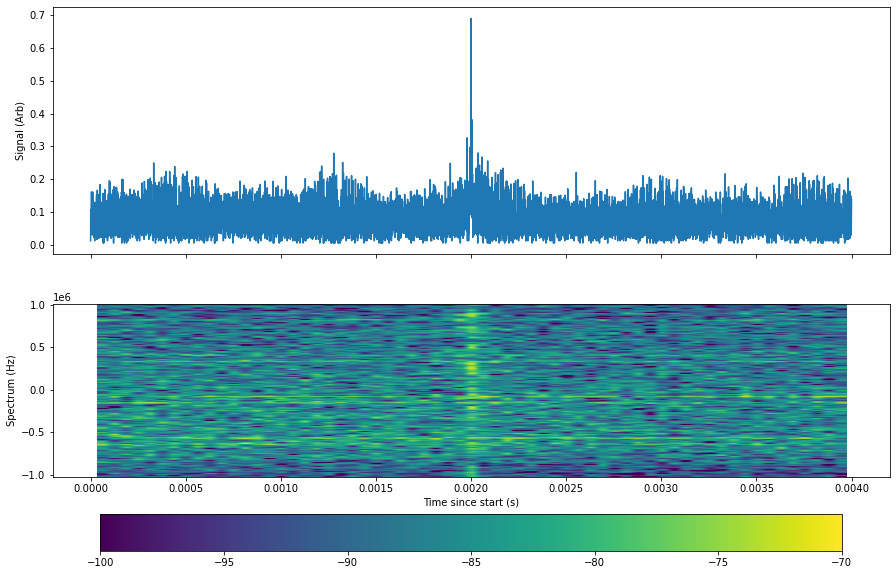

In [19]:
#Code Courtesy of Eric Bruning TTU
#Plot the time series and rolling FFT of the signal

fs = 2.048e6
sub = slice(int(t0*fs),int(t1*fs))

dt = 1./fs
xtime = np.arange(len(ts['sig'])) * dt
myfi, axs = plt.subplots(2,1, figsize=[15,10], sharex=True)
axs[0].plot(xtime[sub]-t0, np.abs(ts['sig'])[sub])

_,_,_,sgimg = axs[1].specgram(ts['sig'][sub], Fs=fs, vmin=-100, vmax=-70)
axs[0].set_ylabel('Signal (Arb)')
axs[1].set_ylabel('Spectrum (Hz)')
axs[1].set_xlabel('Time since start (s)')
plt.colorbar(sgimg, orientation='horizontal', ax=axs[1])

You can see some coherent signals from radio etc... But the lightning impulse is broad band filling the whole bandpass window. 

In [20]:
#The next but of code is designed to look for multiple peaks in the data. 


#First, Smooth the data using a Savgol filter.. otherwise we get too many peaks
filtered_data = signal.savgol_filter(np.abs(ts['sig']),5 ,2)

#Now use SciPy's peak finder to find peaks.. These myst be at least .25 units above noise and 
# at least 10,000 elements apart

locs, props = signal.find_peaks(filtered_data, height = .25, distance = 10000, width = 1)

In [21]:
locs

array([3384026, 3914394, 3953266])

So we have three distinct peaks in this time series.

In [25]:
#Lets make Eric's code into a function

def plot_pulse(ts, time, window):
    t0 = time - window/2.
    t1 =  time + window/2.
    fs = 2.048e6
    sub = slice(int(t0*fs),int(t1*fs))
    dt = 1./fs
    xtime = np.arange(len(ts['sig'])) * dt
    myfi, axs = plt.subplots(2,1, figsize=[15,10], sharex=True)
    axs[0].plot(xtime[sub]-t0, np.abs(ts['sig'])[sub])
    _,_,_,sgimg = axs[1].specgram(ts['sig'][sub], Fs=fs, vmin=-100, vmax=-70)
    axs[0].set_ylabel('Signal (Arb)')
    axs[1].set_ylabel('Spectrum (Hz)')
    axs[1].set_xlabel('Time since start (s)')
    plt.colorbar(sgimg, orientation='horizontal', ax=axs[1])

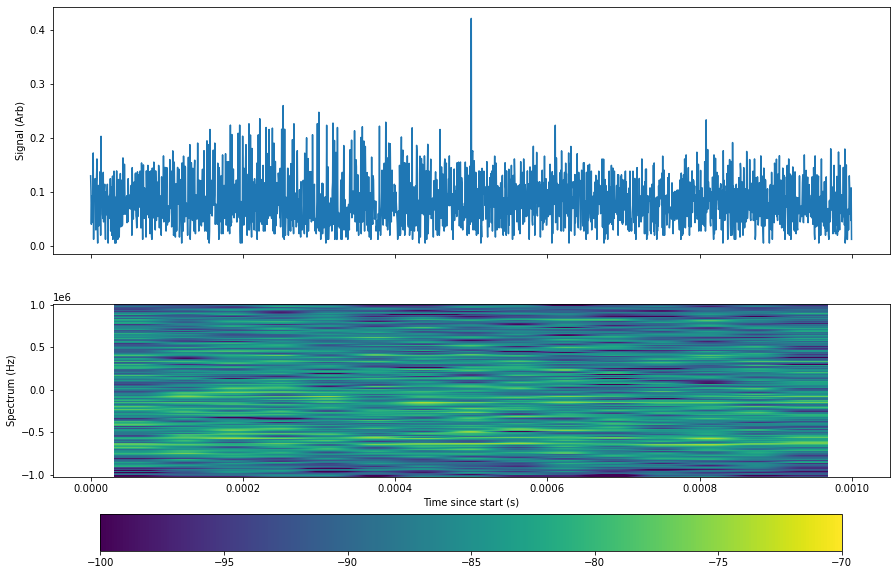

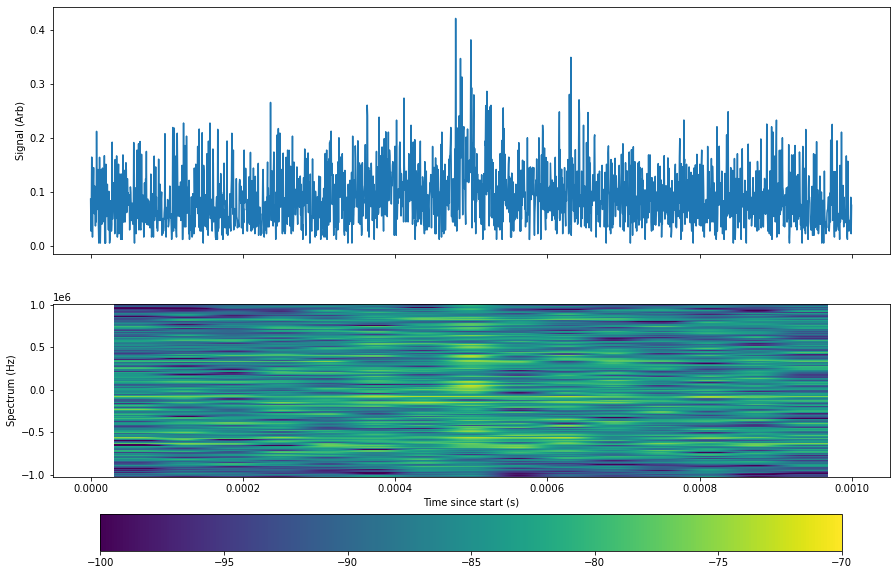

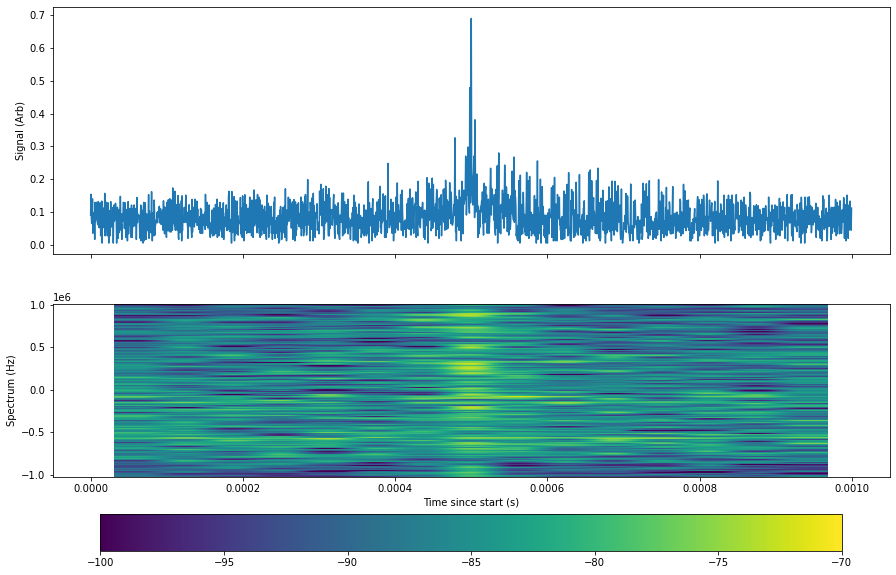

In [27]:
#Now lets loop over all peaks and plot them

for loc in locs:
    plot_pulse(ts, xtime[loc], 1e-3)


2048.0